# Data Science Problem Set 2:

## Fitting and Markov Chain Monte Carlo Techniques with a Fast Radio Burst

Josh Dillon

![](data/frb_artists_rendition.jpg)
**Figure: Artist's rendition of a Fast Radio Burst, via [space.com](https://www.space.com/fast-radio-bursts-rhythm-discovery.html).**

[Fast Radio Bursts](https://en.wikipedia.org/wiki/Fast_radio_burst) (FRBs) are rare but extremely bright pulses of radio emission that can be detected across cosmological distances. The first reported burst was discovered by Duncan Lorimer and David Narkevic in [*Lorimer et al.* (2007)](https://arxiv.org/pdf/0709.4301.pdf) and published in [*Science*](https://science.sciencemag.org/content/318/5851/777), though they found the burst by looking at archival data from 2001. The burst had sat unnoticed in the old [pulsar](https://en.wikipedia.org/wiki/Pulsar) search data from the [Parkes Radio Telescope](https://en.wikipedia.org/wiki/Parkes_Observatory) in Australia for six years! We now call this FRB as the **Lorimer Burst**, though it is also referred to as FRB010724 to refer to the date it was detected. This problem set will have you examining that data and fitting the properties of the burst.

![](data/parkes.jpg)
**Figure: The 64 m Parkes Observatory in New South Wales, Australia.**

(As a fun historical aside, FRBs were initially doubted by many astronomers because the first several were all discovered at Parkes, which also saw many ["perytons"](https://en.wikipedia.org/wiki/Peryton_(astronomy)), detections that looked a lot like FRBs but had clear terrestrial origin. It was eventually discovered that these perytons were caused by observatory staff opening microwave ovens while they were still on, in part because the perytons clustered around lunchtime. This doubt ended when an FRB was discovered at the [Green Bank Telescope](https://en.wikipedia.org/wiki/Green_Bank_Telescope) in 2015.)

FRBs remain an active area of research. Because of the short timescale of the object (usually on the order of milliseconds), the emission must have come from a compact source: the timescales of astrophysical phenomena are generally limited by light travel time across the source and $c \times 1\text{ ms} \approx 300 \text{ km}$. This points to [neutron stars](https://en.wikipedia.org/wiki/Neutron_star), stellar remnants with masses similar to the sun but radii of only ~10 km (yielding densities comparable to atomic nucleii). Because some FRBs have been observed to repeat, this points to a non-cataclysmic origin (i.e. not an explosion like a supernova) and the current leading candidate is that FRBs are created by a class of young neutron stars with extremely large magnetic fields called [magnetars](https://en.wikipedia.org/wiki/Magnetar), which have magnetic fields ~$10^{15}$ times stronger than the Earth's. The exact mechanism is not well understood, though there are [many theories](https://frbtheorycat.org/index.php/Main_Page).

In [1]:
# Let's load up some basic libraries
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# And here are some packages you will need that you might not have. This will install them in your python environment.
%pip install tqdm # This module lets you creative live progress bars on code in notebooks
%pip install emcee # This module is useful for accelerating high-dimentional MCMCs
%pip install corner # This module makes nice corner plots to show the output of an MCMC

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Problem 1: Visualizing FRBs and Downsampling in Time

[Archival data for several Parkes FRBs can be found here](https://data-portal.hpc.swin.edu.au/dataset/parkes-frbs-archival-data), though lots more FRBs are included in the catalog at http://frbcat.org/. I've downloaded the relevant data from the Lorimer burst in ASCII format for you and put in it the `data` folder where you found this notebook.

![](data/lorimer_beam_map.png)
**Figure: Figure 1 of [Lorimer et al. (2007)](https://arxiv.org/pdf/0709.4301.pdf) showing H$\alpha$ emission (gray scale) and 21 cm emission (contours) of the [Small Megallanic Cloud (SMC)](https://en.wikipedia.org/wiki/Small_Magellanic_Cloud). While the observation was looking for pulsars in the SMC, the FRB actually came from a background galaxy from much further way. While Parkes has a single dish, the data were taken from multiple feeds sitting near the focus of that dish. As a result, each one was sensitive to a slightly different part of the sky. This lead to 13 different beams, shown as circles denoting the half-power width of each beam (the point at which each beam is half as sensitive as it is at its peak.) FRB010724 was detected in three different beams, 6, 7 and 13 though the detection in beam 6 was so bright that it saturated the digitizer for that beam (denoted with a square). Likely the source was somewhere between these three beams, closest to beam 6, though it was never precisely localized to a specific background object.**

I've included just the three beams where the FRB was detected, 6, 7 and 13. The data are 2 second samples from around the burst with 1 ms temporal resolution and 96 frequency channels spanning 288 MHz, centered on 1374 MHz. Let's go ahead and plot those dynamic spectra (frequency vs. time).

In [3]:
# this metadata can be found in the './data/*.head' header files, which can be opened in any text editor
temporal_resolution = .001 # seconds
center_freq = 1374 # MHz
bandwidth = 288 # MHz

<IPython.core.display.Javascript object>


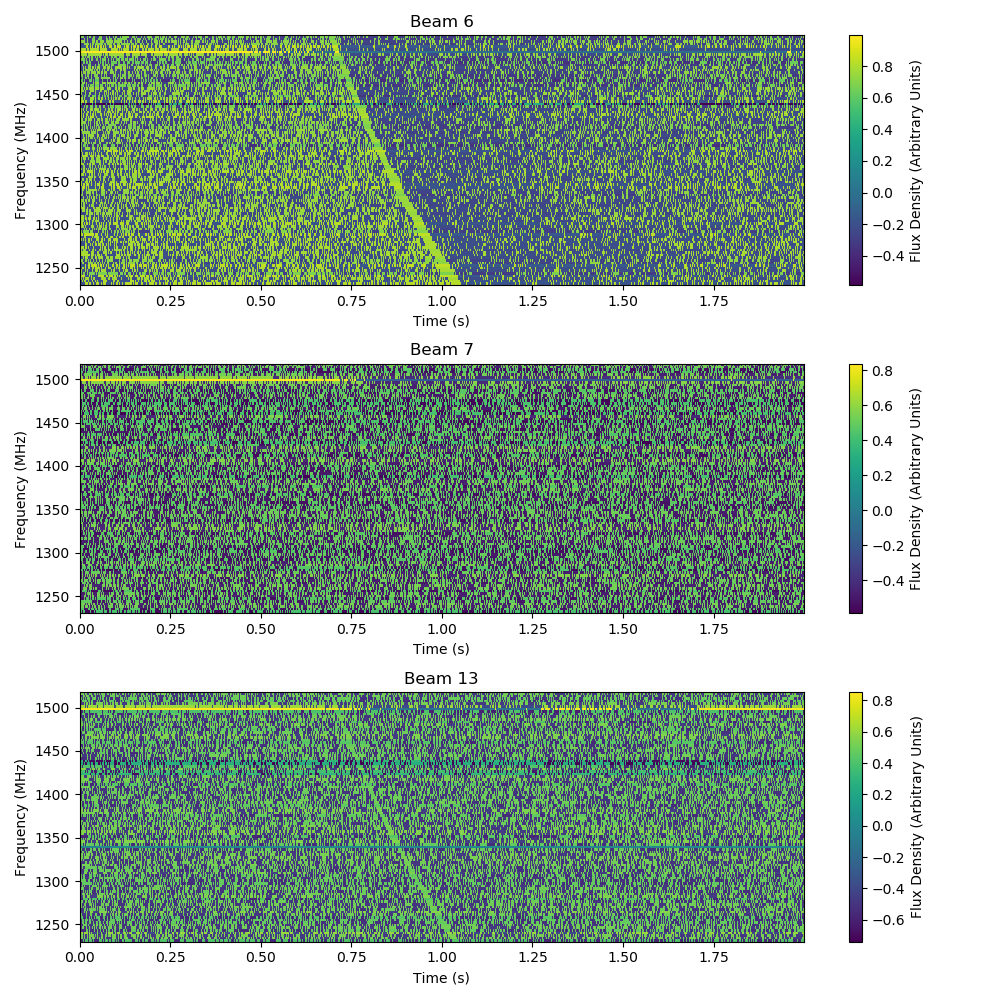

In [4]:
# Now let's plot the burst for each of the three beams
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

raw_amplitudes = {}
for file, beam, ax in zip(['./data/6.raw.cube', './data/7.raw.cube', './data/D.raw.cube'], [6, 7, 13], axes):
    # load ascii data, which is formatted as three columns: channel number, integration number, and measurement
    chans, ints, amps = np.loadtxt(file).T
    nChans = len(np.unique(chans))
    raw_nInts = len(np.unique(ints))
    raw_amplitudes[beam] = amps.reshape(nChans, raw_nInts)
    
    # compute times and frequencies 
    freqs = np.linspace(center_freq - bandwidth / 2, center_freq + bandwidth / 2, nChans)
    raw_times = np.arange(0, temporal_resolution * raw_nInts, temporal_resolution)
    
    # plot signals
    im = ax.imshow(raw_amplitudes[beam], aspect='auto',
                   extent=[raw_times[0], raw_times[-1], freqs[0], freqs[-1]])
    plt.colorbar(im, ax=ax, label='Flux Density (Arbitrary Units)')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'Beam {beam}')
plt.tight_layout()

In addition to the burst, which is narrow but shows a clear frequency dependence in its arrival time, there's also a few frequency channels that are either malfunctioning or clearly contaminated by interference. We're going to flag those by setting them to `np.nan` and then making sure they are given no weight in any future analysis. This whay, when we use functions like `np.nansum` or `np.nanmean` or `np.nanstd`, the `np.nan` values are skipped in the calculation. Another nice thing about setting them to `np.nan` is that `plt.imshow` will show them as white, making them clearly distinguishable from 0 without screwing up the colorbar. 

In [5]:
# Flag RFI and malfuncitoning channels
for beam in raw_amplitudes:
    raw_amplitudes[beam][5:8, :] = np.nan
    raw_amplitudes[beam][26, :] = np.nan
raw_amplitudes[13][59, :] = np.nan

One interesting aspect of this data is that they were sampled with a single bit (i.e. the raw data, before corrections were applied, literally measured 1 or 0 in each time/frequency pixel.) To see the bursts more clearly, it is useful to average neighboring times together. This is how Figure 2 of [Lorimer et al. (2007)](https://arxiv.org/pdf/0709.4301.pdf) was produced.

### Average the amplitudes in 4 ms chunks, producing a new dictionary called `amplitudes` mapping beam number to `numpy` arrays. Also average times together to get a new `times` array.

<IPython.core.display.Javascript object>


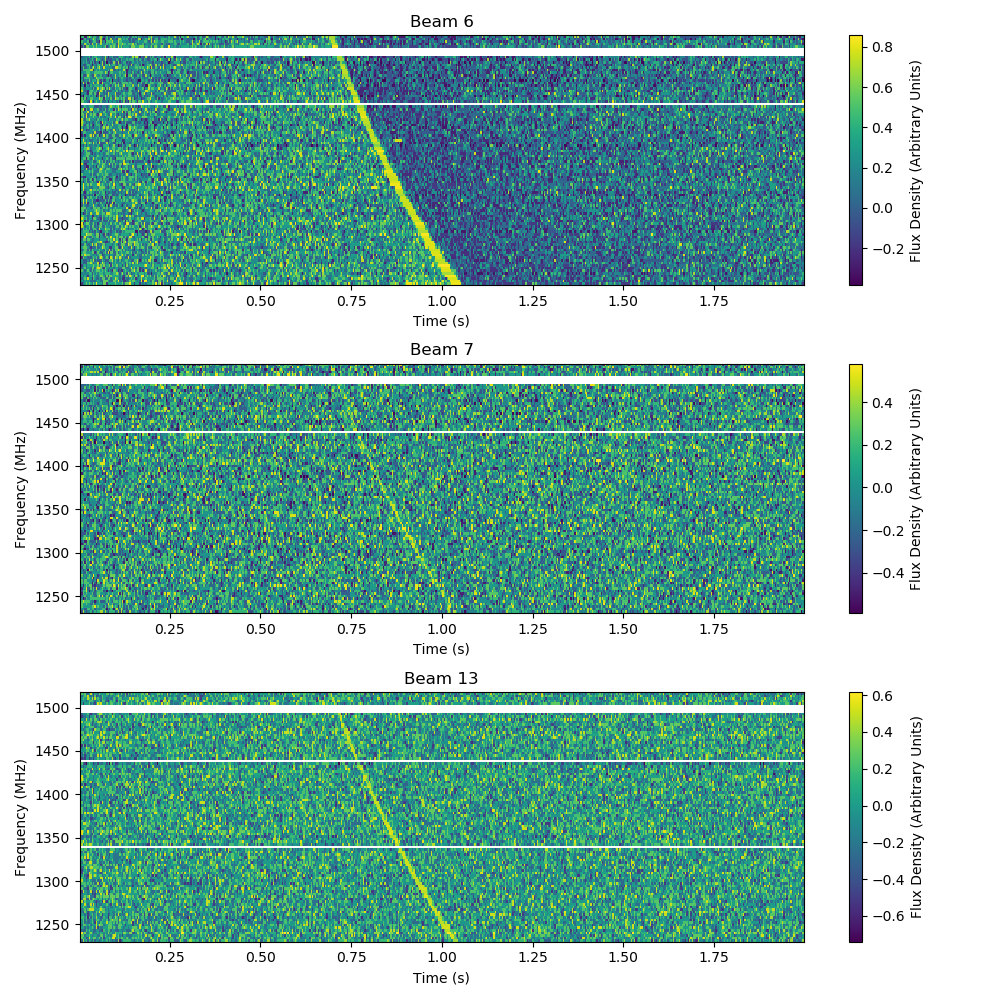

In [6]:
# Your code here. When you are done, the following two variables should be defined:
# amplitudes = 
# times =

# Use np.reshape to reshape the time dimension from (2000,) to (500, 4), then average along the second time axis
nInts = raw_nInts // 4
amplitudes = {beam: np.mean(np.reshape(amp, (nChans, nInts, 4)), axis=2) for beam, amp in raw_amplitudes.items()}
times = np.mean(np.reshape(raw_times, (-1, 4)), axis=1)

# Plot time-averaged signals
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
for beam, ax in zip([6, 7, 13], axes):  
    # plot signals
    im = ax.imshow(amplitudes[beam], aspect='auto',
                   extent=[times[0], times[-1], freqs[0], freqs[-1]])
    plt.colorbar(im, ax=ax, label='Flux Density (Arbitrary Units)')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'Beam {beam}')
plt.tight_layout()

You should find that the burst is now much clearer for beams 7 and 13. You may also notice that after the burst in Beam 6, the background amplitude goes strongly negative. This is a consequence of the over-saturation of the 1-bit digitizer. This is clearly the largest signal, but the nonlinear instrumental response makes it harder to analyze. That's why, for the rest of this problem set, we will use beam 13, which is the one shown in [Lorimer et al. (2007)](https://arxiv.org/pdf/0709.4301.pdf).

In [7]:
beam = 13

## Problem 2: Fitting an FRB model

The most notable feature in the dynamic spectra of the FRB010724 (and of all FRBs), besides its bright, short-duration pulse, is the frequency-dependent arrival time of the burst. This *dispersion* is a consequence of the fact that the speed of light is not the same for all frequencies of light in many media (like prisms). In particular, the space between galaxies is filled with sparse plasma. The integral of the electron number density along the line of sight at distance $d$ to the source gives us its *dispersion measure* (DM):

\begin{equation}
DM \equiv \int_0^d n_e(l) dl
\end{equation}

The dispersion measure is traditionally measured in units of cm$^{-3}$ pc. As Equation 1 of [Lorimer et al. (2007)](https://arxiv.org/pdf/0709.4301.pdf) states, the differential arrival time of a dispersed pulse between two frequencies $\nu_{low}$ and $\nu_{high}$ is given by:

\begin{equation}
\Delta t = 4.148808\text{ ms} \times \left[\left(\frac{\nu_{low}}{\text{GHz}}\right)^{-2} - \left(\frac{\nu_{high}}{\text{GHz}}\right)^{-2}\right] \times \left(\frac{DM}{\text{cm}^{-3}\text{pc}}\right).
\end{equation}

What is particularly notable is that the measured DM (>300) is difficult to explain due ionized gas within the Milky Way. Along the direction to the source, only about 25 cm$^{-3}$ pc could be explained by local dispersion of the burst. The rest of the integral must have either come from the region around the source itself or the intergalactic medium (IGM). If the rest of the dispersion were entirely due to the IGM, Lorimer et al. argue that this would put the distance to the source at roughly 1 Gpc, roughly 3 billion light years away! 

To measure the DM and the other properties of the burst, we will need a model. To do that, I've created a function for you called `generate_gaussian_frb` below. The idea is to model the FRB as a Gaussian with amplitude `amp` and frequency-dependent center time. As Lorimer argue, the width of the pulse should scale as $\nu^{-4}$ power to scattering in the intervening medium, so the $\sigma$ of that Gaussian is given by:

\begin{equation}
\sigma(\nu) = \frac{1}{2\sqrt{2 \ln 2}} FWHM(\nu) = \frac{1}{2\sqrt{2 \ln 2}} FWHM(\nu_{high}) \left[\frac{\nu}{\nu_{high}}\right]^{-4}
\end{equation}

So to produce a model, we have a Gaussian profile at $\nu_{high}$ centered at $t(\nu_{high})$, with full-width at half-maximum given by $FWHM(\nu_{high})$ and amplitude $A$ (for our purposes, let's not worry about the units of this, since the amplitude is multiplied by an unknown beam value) and dispersion measure $DM$:

In [8]:
# We use np.meshgrid to create arrays the size of nInt by nChan with the value of the time or 
# frequency at a given point. This is especially useful for performing calculations at all
# time and frequencies, as we do below.
time_grid, freq_grid = np.meshgrid(times, freqs[::-1])

# function defining our model for an FRB dynamic spectrum
def generate_gaussian_frb(grids_tuple, time_high_f, DM, amp, FWHM_high_f, ravel=True):
    '''Generate a dispersed and scattered burst with given parameters. The burst
    is assumed to have a Gaussian profile, a constant amplitude as a function of frequency
    and a pulse width that narrows with increasing frequency as freq^-4.
    
    Arguments:
        grids_tuple: tuple of (time_grid, freq_grid) the size and shape of the output
            simulated waterfall. These can be created with np.meshgrid(). Time 
            assumed to be in seconds, frequency assumed to be in MHz.
        time_high_f: arrival time in seconds of the burst at the highest freq in freq_grid
        DM: dispersion measure assumed to be in pc / cm^3
        amp: frequency-independent amplitude of the pulse in arbitary units. 
        FWHM_high_f: full-width at half-maximum in seconds of the Gaussian pulse at the
            highest frequency in freq_grid. 
            
    Returns:
        frb: either a 2D array (if ravel is False) of the simulated pulse waterfall on the
            input time and frequency meshgrids or a 1D array after np.ravel(). 
    '''
    (time_grid, freq_grid) = grids_tuple
    delta_t = 4.148808 /1e3 * ((freq_grid / 1e3)**-2 - (np.max(freqs) / 1e3)**-2) * DM
    FWHM = FWHM_high_f * (freq_grid / np.max(freqs))**-4
    sigma = FWHM / (2**1.5 * np.log(2)**.5)
    frb = amp * np.exp(-(time_grid - (time_high_f + delta_t))**2 / 2 / sigma**2)
    
    if ravel: # for fitting, it's useful to ravel(). For plotting, it's easier not to.
        return frb.ravel()
    return frb

### Given this model, use `scipy.optimize.curve_fit` to solve for the arrival time, DM, pulse width, and apparent amplitude in Beam 13 at 4 ms resolution. Then plot the burst, the model of the burst evaluated at your best fit values for the four parameters, and the residual between the two.

***Hints: be sure to read the [documentation of `curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). Note that `curve_fit` fits 1D functions, so you'll want to use `np.ravel()` to turn 2D functions (like dynamic spectra) into 1D functions. In general, curve fitting functions are iterative algorithms that look for convergence. To prevent the fitter from diverging or finding local minima that aren't the global optimal value, try bounding the parameters within the founding ranges:***
* $0 \leq t(\nu_{high}) \leq 2$
* $10 \leq DM \leq 1000$
* $.1 \leq A \leq 1$
* $.004 \leq FWHM(\nu_{high}) \leq .1$

<IPython.core.display.Javascript object>


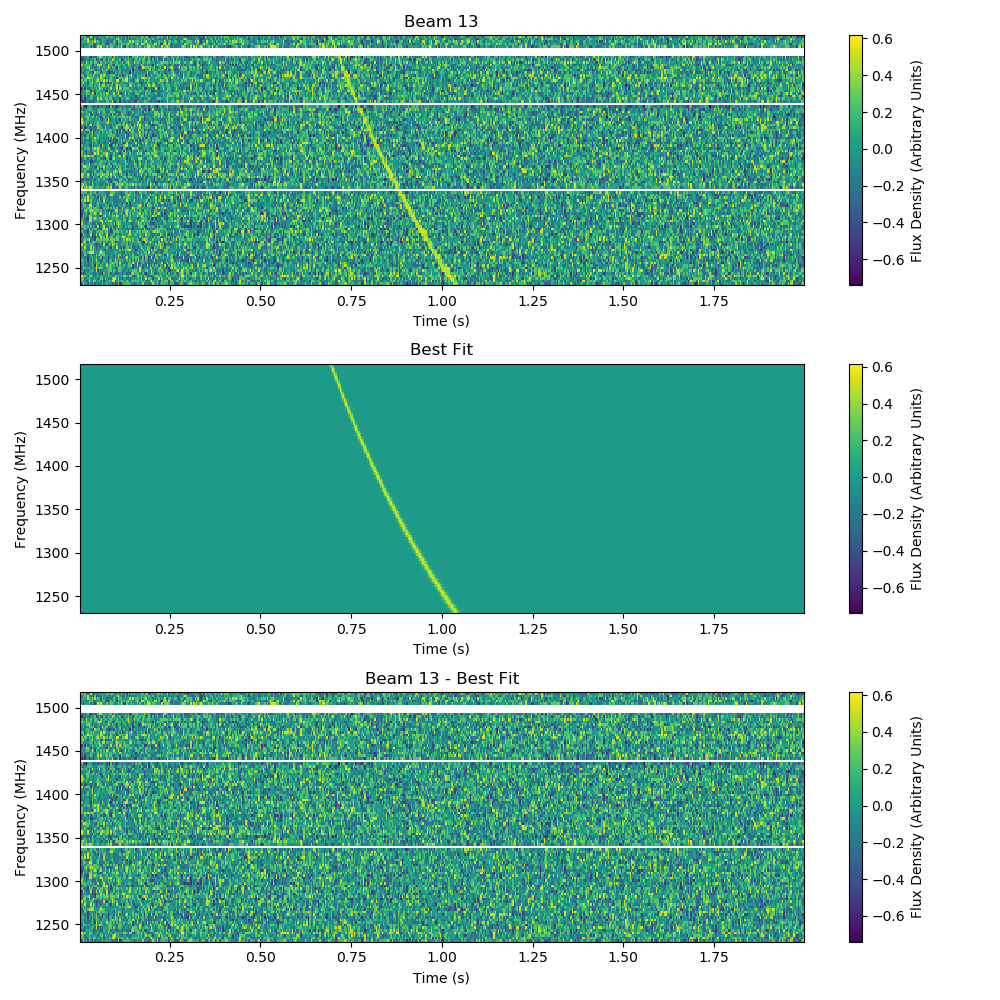

In [9]:
# give all pixels equal weights (given by 1/sigma^2), except the flagged channels
sigma = np.ones_like(amplitudes[beam])
sigma[~np.isfinite(amplitudes[beam])] = np.inf

# set nans to 0 in the data
to_fit = copy.deepcopy(amplitudes[beam]) 
to_fit[~np.isfinite(amplitudes[beam])] = 0

# fit input parameters to generate_gaussian_frb()
from scipy.optimize import curve_fit
fit, _ = curve_fit(# your code here, `fit` should be a length-4 array of the 4 best-fit parameters
                   generate_gaussian_frb, (time_grid, freq_grid), to_fit.ravel(), 
                   p0=(.7, 300, .6, .03), sigma=sigma.ravel(),
                   bounds=([0, 10, .1, .004], [2, 1000, 1, .1]))

# generate model from fit
best_fit_model = generate_gaussian_frb((time_grid, freq_grid), *fit, ravel=False)

# plot data, model, and difference
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
for data, title, ax in zip([amplitudes[beam], best_fit_model, amplitudes[beam] - best_fit_model], 
                           [f'Beam {beam}', 'Best Fit', f'Beam {beam} - Best Fit'], axes):  
    im = ax.imshow(data, aspect='auto', 
                   vmin=np.nanmin(amplitudes[beam]), vmax=np.nanmax(amplitudes[beam]), 
                   extent=[times[0], times[-1], freqs[0], freqs[-1]])
    plt.colorbar(im, ax=ax, label='Flux Density (Arbitrary Units)')
    ax.set_ylabel('Frequency (MHz)')
    ax.set_xlabel('Time (s)')
    ax.set_title(title)
plt.tight_layout()

If you did this right, the residual of the data after subtracting the best-fit model should a lot like noise.

## Problem 3: Looking at the $\chi^2$ of your fit as a function of DM.

What does it mean for a fit to be "good"? After all, we don't expect the fit to the perfect if the data are noisy. If it was, that probably means that the model has too many free parameters and we're "overfitting the noise," meaning that the model is too complicated and we're ascribing physical significance to random fluctuations. (Model selection and model comparison are rich topics for another day.) In general, a good model is one whose differences from the data are consistent with the expected noise in the measurement. We can quantify this by computing $\chi^2$ for a given set of data points $d_i$ and model points $m_i$ computed from a set of model parameters $\vec{\theta}$ with expected noise variance $\sigma_i^2$:

\begin{equation}
\chi^2(\vec{\theta}) = \sum_i \frac{\left | d_i - m_i(\vec{\theta})\right |^2}{\sigma_i^2}
\end{equation}

Setting aside the question of whether the model is consistent with the data up to the noise, one can generally say that, for a given model, the set of parameters that minimizes $\chi^2$ is the "best fit." This is effectively what `scipy.optimize.curve_fit` is doing.

To look at $\chi^2$ more closely, let's compute it ourselves for a variety of values of DM around the best fit found above, keeping the other parameters constant. To start, we need to calculate $\sigma_i$, the standard deviation of the noise at each time and frequency. For this problem set, we'll assume that it's a constant and so we'll use a very simple estimate the noise by looking at the standard deviation of the unflagged data after subtracting the best-fit model. 

In [10]:
best_fit_model = generate_gaussian_frb((time_grid, freq_grid), *fit, ravel=False)
sigma = np.nanstd(amplitudes[beam] - best_fit_model)

### Now plot $\chi^2$ defined above as a function of DM in the range 350 cm$^{-3}$ pc $\leq$ DM $\leq$ 370 cm$^{-3}$ pc, a range which should include your best fit, holding all other parameters constant at their best fit values. In addition, plot the residual dynamic spectrum for a handful of DMs in that range so you can see by eye what better and worse fits look like.

<IPython.core.display.Javascript object>


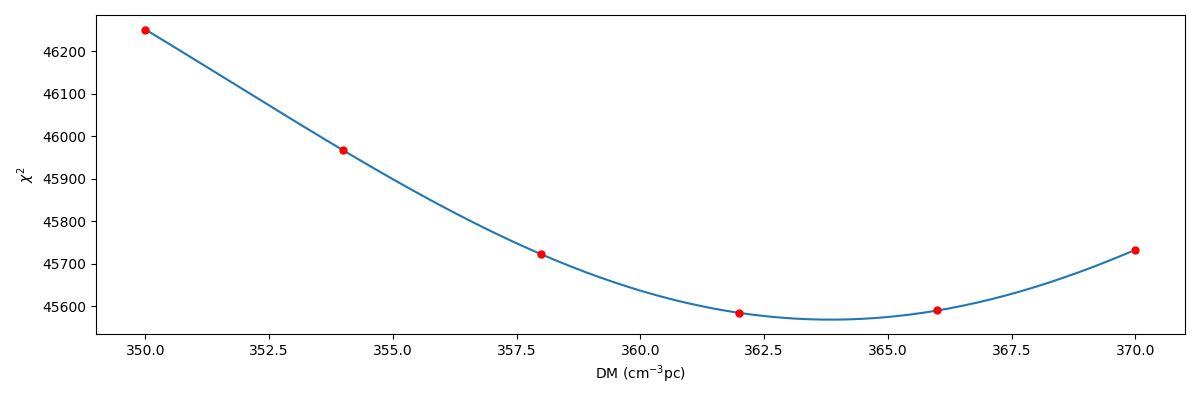

<IPython.core.display.Javascript object>


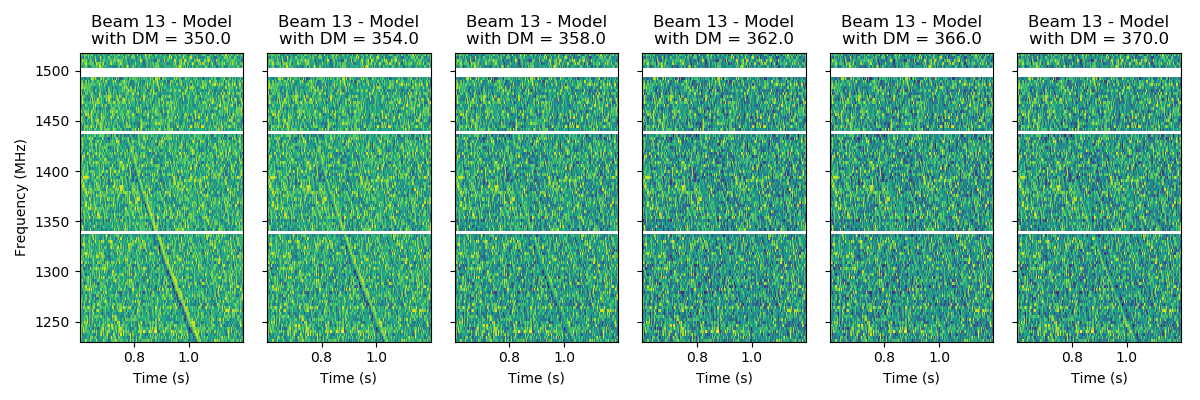

In [11]:
# your code here:
DMs = np.arange(350, 370, .1)
chisqs = []

# compute chisq for every value of DM
for DM in DMs:
    model = generate_gaussian_frb((time_grid, freq_grid), fit[0], DM, fit[2], fit[3], ravel=False)
    chisqs.append(np.nansum(np.abs(amplitudes[beam] - model)**2 / sigma**2)) 

# plot chi^2 as a function of DM
fig1, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(DMs, chisqs)
ax1.set_xlabel('DM (cm$^{-3}$pc)')
ax1.set_ylabel('$\chi^2$')
plt.tight_layout()

# now loop over 6 example DMs in the range 350 to 370
fig2, axes = plt.subplots(1, 6, figsize=(12,4), sharey=True)
for DM, ax in zip(np.linspace(350, 370, 6), axes):
    # compute the model burst for each of these example DMs
    model = generate_gaussian_frb((time_grid, freq_grid), fit[0], DM, fit[2], fit[3], ravel=False)

    # plot in red the points in the top figure that we're showing the residuals for in the bottom figure
    chisq = np.nansum(np.abs(amplitudes[beam] - model)**2 / sigma**2)
    ax1.plot(DM, chisq, 'r.', ms=10)
                  
    time_subset = (times > .6) & (times < 1.2)
    ax.imshow((amplitudes[beam] - model)[:, time_subset], aspect='auto',
              extent=[times[time_subset][0], times[time_subset][-1], freqs[0], freqs[-1]])
    ax.set_title(f'Beam {beam} - Model\nwith DM = {DM}')
    ax.set_xlabel('Time (s)')
axes[0].set_ylabel('Frequency (MHz)')
plt.tight_layout()

## Problem 4: Building a 1D MCMC with the Metropolis-Hastings Algorithm

Science is not just about what you know, it's about how well you know it. It's never good enough to simply report a measurement without also reporting your uncertainty on that measurement. Usually this comes in the form of error bars. What do we mean if we measure a number to be $13\pm2$ at 95% confidence? Generally, it means that we're assuming the noise in our measurement is [normally distributed](https://en.wikipedia.org/wiki/Normal_distribution) (often a reasonable assumption, given the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem)) with $\sigma = 1$ and that, given our understanding of the noise on our measurement, there's a 95% chance that if we conducted the same experiment again, the measurement would fall in that range. That's because 95% of the area under the curve of a Gaussian falls within the range of $\pm 2\sigma$. 

Even if the noise in each individual time and frequency were well-described by a Gaussian (and it's not exactly, though averaging in time helps make it more Gaussian), it's not obvious what the "noise" on the final  measurement of, for example, DM should be or even if those errors are Gaussian-distributed. However, there is a very general class of algorithms that helps us estimate the probability distribution. These algorithms, known as Markov Chain Monte Carlo (MCMC), allow us to explore the space of parameters and create a distribution of samples drawn from the underlying probability distribution that we're interested in--the probability distribution that describes our measurement and our uncertainty on it. If we want, we can summarize these distributions with statistics like $\sigma$, but that's merely a matter of convenience; ultimately the distribution itself contains the full extent of our information.

In general in statistics, we're interested in the question of how likely it is that our parameters of interest have some value, given the measurement we made and what we know about it. We write this as $P(\vec{\theta} | \vec{d})$ and call it the *posterior probability* because it reflects our knowledge after the measurement was made (at least in the [Bayesian philosophy of probability](https://en.wikipedia.org/wiki/Bayesian_probability), but that's a whole other topic). This question can be answered with [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem): 

\begin{equation}
P(\vec{\theta} | \vec{d}) = \frac{P(\vec{d} | \vec{\theta}) P(\vec{\theta})}{P(\vec{d})},
\end{equation}

where $P(\vec{d} | \vec{\theta})$ is the *likelihood* of having gotten the data that we did, assuming our model and its parameters are right and $P(\vec{\theta})$ is our *prior* probability estimate that our model is right. (We often ignore $P(\vec{d})$ the so-called *evidence* because it does not depend on $\vec{\theta}$, it is often difficult to calculate directly, and can usually be accounted for by normalizing the final posterior distribution to integrate to 1.)

The key idea a MCMC is that it randomly samples the model parameters in a way that's proportional to the posterior. Here's the basic procedure for the simplest MCMC, the [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm):

1. Start with some guess set of parameters $\vec{\theta}_0$, perhaps some best fit but it can be anything reasonable. 
2. Pick another random set of parameters $\vec{\theta}_1$ from the prior probability distribution $P(\vec{\theta})$. 
3. Calculate an "acceptance" ratio of the posteriors using Bayes' theorem: 
\begin{equation}
\frac{P(\vec{d} | \vec{\theta}_1) P(\vec{\theta}_1)}{P(\vec{d} | \vec{\theta}_0) P(\vec{\theta}_0)}
\end{equation}
4. If that ratio is greater than 1 *accept* the new set of parameters and add it to your list of accepted parameters. If that ratio is less than 1, then pick a random number uniformly distributed between 0 and 1. If your random number is less than your ratio, accept the new set of parameters and add it to your list. Otherwise reject it. 
5. If you accepted the new set of parameters, make them your new $\vec{\theta}_0$.
6. Now return to to step 2 and continue into your list of accepted parameter values is long enough to effectively describe underlying probability distribution.

This algorithm uses a [Markov chain](https://en.wikipedia.org/wiki/Markov_chain), a random process that only depends on the previous state, to eventually map out the final posterior probability distribution. 

It is often useful to throw away the first several points, since you don't really know if your starting point was representative of the final distribution. Generally speaking, Markov chains tend to lose "memory" of their starting positions, so throwing away some fraction of initial draws is considered best practice. We call this process "burn-in" and it's a bit of an art to figure out how many points to burn. Generally, if you throw out enough points so that the first samples in the chain aren't outliers, you've burned in enough.

For the purposes of this problem set, we're going to make two simplifying assumptions. First we're going to assume uniform priors on the parameters. That means that $P(\vec{\theta})$ is constant inside the bounds on the parameter and 0 outside. So as long as $\vec{\theta}_1$ and $\vec{\theta}_0$ are in bounds, the prior terms cancel the acceptance ratio. Second, we're going to assume that each data point has independent, Gaussian-distributed noise. Thus, the likelihood of a given measurement is simply the product of the probabilities of each individual measurement. Up to an overall normalization, this is given by:

\begin{equation}
P(\vec{d} | \vec{\theta}) \propto \Pi_i \exp \left[\frac{-\left|d_i - m_i(\vec{\theta}) \right|^2}{2 \sigma_i^2} \right] = e^{-\chi^2 / 2}.
\end{equation}

Thus, the acceptance ratio can be calculated simply as 
\begin{equation}
\frac{P(\vec{d} | \vec{\theta}_1)}{P(\vec{d} | \vec{\theta}_0)} = e^{-(\chi^2_1 - \chi^2_0)/2}.
\end{equation}

For more on MCMCs and I found [this tutorial](https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html) and 
and [this memo](https://library.nrao.edu/public/memos/evla/EVLAM_102.pdf) quote useful. 

### Implement the Metropolis-Hastings algorithm sample the distribution of values for DM, holding all other parameters fixed at their best-fit values. 
* ### Try 10,000 proposed values of DM, drawn uniformly from the range 350 cm$^{-3}$ pc $\leq$ DM $\leq$ 370 cm$^{-3}$ pc, but use the first 10% of your accepted samples as burn-in. 
* ### Plot the accepted proposals for both the burn-in and final sample. 
* ### Plot a histrogram of the posteriori distribution of DM from the accepted, non-burned draws.



From 10000 proposals, 747 (7.47%) were accepted.
Of these, 74 were thrown away as burn-in.


<IPython.core.display.Javascript object>


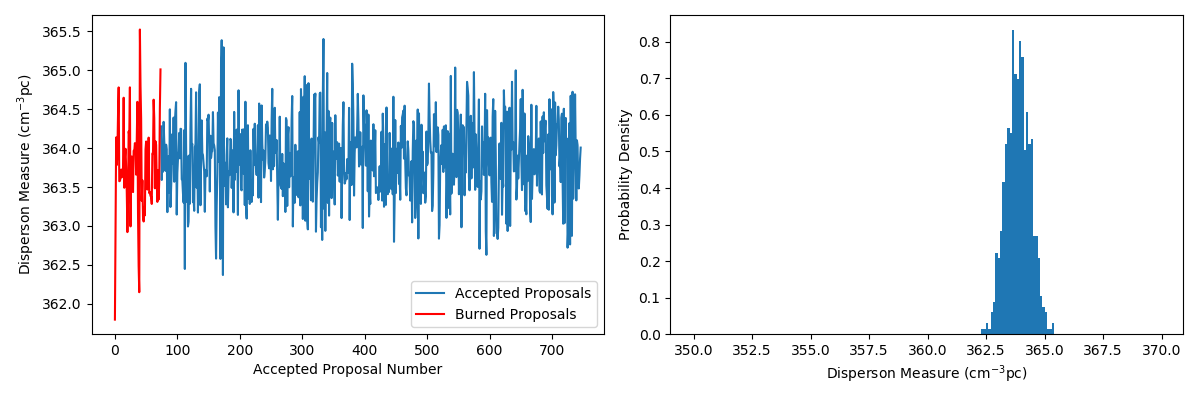

In [12]:
nProposals = 10000

accepted_DMs = [] # this list keeps all the accepted proposals
prior_DM = [350, 370] # this is the range you want to draw from uniformly
current_DM = 370 # this is your starting value, which will get updated each time you accept a proposal

# calculate noise, model, chisq as we did above
sigma = np.nanstd(amplitudes[beam] - best_fit_model) 
current_model = generate_gaussian_frb((time_grid, freq_grid), fit[0], current_DM, fit[2], fit[3], ravel=False)
current_chisq = np.nansum(np.abs(amplitudes[beam] - current_model)**2 / sigma**2)

# tqdm is a nice module for adding interactive progress bars to your jupyter notebooks.
# All you have to do is wrap any iterable that you're looping over with tqdm().
from tqdm.notebook import tqdm
for i in tqdm(range(nProposals)): 
    # your code here:
    # draw a new proposal uniformly from the range in prior_DM
    proposed_DM = np.random.uniform(*prior_DM)
    # calculate a new model with that DM (and the other best fit parameters) and the chisq of that model
    proposed_model = generate_gaussian_frb((time_grid, freq_grid), fit[0], proposed_DM, fit[2], fit[3], ravel=False)
    proposed_chisq = np.nansum(np.abs(amplitudes[beam] - proposed_model)**2 / sigma**2)
    # calculate the acceptance ratio
    acceptance_probability = np.exp(-(proposed_chisq - current_chisq)/2)
    if acceptance_probability >= 1 or (np.random.rand() > 1 - acceptance_probability):
        # if the proposal is accepted, update the current DM and current model
        accepted_DMs.append(proposed_DM)
        current_DM = proposed_DM
        current_model = proposed_model
        current_chisq = proposed_chisq
        
# Print some statistics about the acceptance fraction and the number of burned proposals. Separate final proposals from burned ones.
print(f'From {nProposals} proposals, {len(accepted_DMs)} ({np.round(100 * len(accepted_DMs) / nProposals, 2)}%) were accepted.')
nBurn = len(accepted_DMs) // 10
burned_DMs = accepted_DMs[:nBurn]
accepted_DMs = accepted_DMs[nBurn:]
print(f'Of these, {nBurn} were thrown away as burn-in.')        

# now plot final result
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# plot accepted proposals, with burned ones in red to see whether enough proposals 
# were burned to erase the memory of the starting position
axes[0].plot(np.arange(len(accepted_DMs)) + nBurn, accepted_DMs, label='Accepted Proposals')
axes[0].plot(np.arange(nBurn), burned_DMs, 'r', label='Burned Proposals')
axes[0].set_xlabel('Accepted Proposal Number')
axes[0].set_ylabel('Disperson Measure (cm$^{-3}$pc)')
axes[0].legend()

axes[1].hist(accepted_DMs, np.arange(*prior_DM, .1), density=True)
axes[1].set_xlabel('Disperson Measure (cm$^{-3}$pc)')
axes[1].set_ylabel('Probability Density')

plt.tight_layout()

## Problem 5: Generalizing to 2D MCMCs to constrain DM and $t(\nu_{high})$ simultaneously

One important aspect of MCMCs is that they can help us uncover posteriors beyond simple Gaussians. The posterior can be any shape and in general the posterior distribution for one parameter will look different for different values of the other parameters. In Problem 3, you hopefully saw that increasing the DM made the burst arrive earlier or later in the residuals. So you might guess that if you get the DM a little too high, you might get almost as good of a fit if you also made $t(\nu_{high})$ a little smaller to compensate. These parameters are *correlated* and understanding the correlations between parameters in our posteriors is extremely important to understanding our measurements and their errors.

### Implement the Metropolis-Hastings algorithm sample the distribution of values for DM and $t(\nu_{high})$ simultaneously, holding the other parameters fixed at their best-fit values. 
* ### Try 50,000 proposed values of the two parameters, drawn uniformly from the range 359 cm$^{-3}$ pc $\leq$ DM $\leq$ 369 cm$^{-3}$ pc and .685 s $\leq$ $t(\nu_{high})$ $\leq$ .7 s. 
* ### Again, use the first 10% of your accepted samples as burn-in. 
* ### Plot the accepted proposals for both the burn-in and final sample, this time as a scatter plot.
* ### Use `np.histogram2d` to make a 2D histogram of your accepted, non-burned draws. 
* ### Note the fraction of accepted proposals--how does it compare to the one in Problem 4?


From 50000 proposals, 749 (1.5%) were accepted.
Of these, 74 were thrown away as burn-in.


<IPython.core.display.Javascript object>


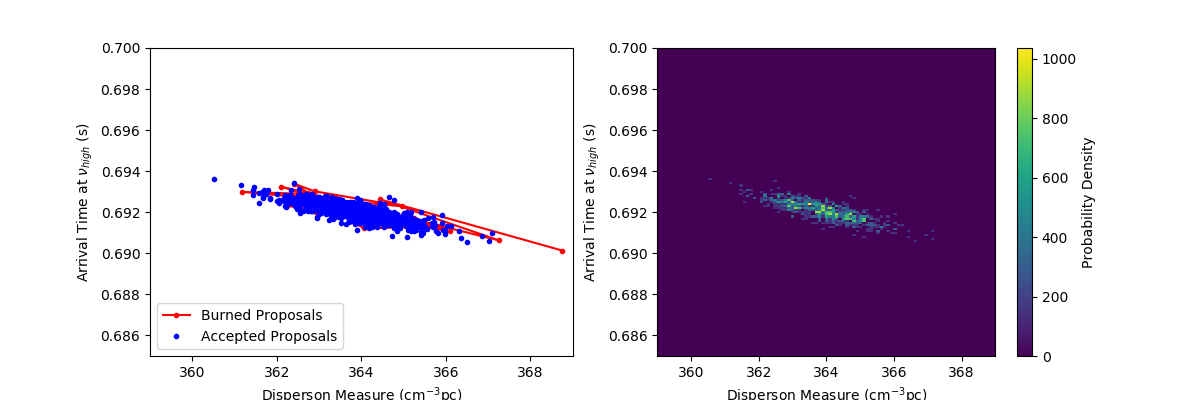

In [13]:
# your code here: When you are done, the following two variables should be defined:
# accepted_time_high_fs = 
# accepted_DMs = 
nProposals = 50000

accepted_time_high_fs = []
prior_time_high_f = [.685, .7]
current_time_high_f = .7

accepted_DMs = []
prior_DM = [359, 369]
current_DM = 360

# again, compute the noise and the current model and chisq
sigma = np.nanstd(amplitudes[beam] - best_fit_model)
current_model = generate_gaussian_frb((time_grid, freq_grid), current_time_high_f, current_DM, fit[2], fit[3], ravel=False)
current_chisq = np.nansum(np.abs(amplitudes[beam] - current_model)**2 / sigma**2)

for i in tqdm(range(nProposals)):
    # generate proposals for time_high_f and DM from the bounds
    proposed_time_high_f = np.random.uniform(*prior_time_high_f)
    proposed_DM = np.random.uniform(*prior_DM)
    
    # compute porposed model and chisq
    proposed_model = generate_gaussian_frb((time_grid, freq_grid), proposed_time_high_f, proposed_DM, fit[2], fit[3], ravel=False)
    proposed_chisq = np.nansum(np.abs(amplitudes[beam] - proposed_model)**2 / sigma**2)
    
    # determine whether to accept the proposal and, if so, update the current values
    acceptance_probability = np.exp(-(proposed_chisq - current_chisq)/2)
    if acceptance_probability >= 1 or (np.random.rand() > 1 - acceptance_probability):
        accepted_time_high_fs.append(proposed_time_high_f)
        accepted_DMs.append(proposed_DM)
        
        current_time_high_f = proposed_time_high_f
        current_DM = proposed_DM
        current_model = proposed_model
        current_chisq = proposed_chisq

# Print some statistics about the acceptance fraction and the number of burned proposals. Separate final proposals from burned ones.
print(f'From {nProposals} proposals, {len(accepted_DMs)} ({np.round(100 * len(accepted_DMs) / nProposals, 2)}%) were accepted.')
nBurn = len(accepted_DMs) // 10
burned_time_high_fs = accepted_time_high_fs[:nBurn]
accepted_time_high_fs = accepted_time_high_fs[nBurn:]
burned_DMs = accepted_DMs[:nBurn]
accepted_DMs = accepted_DMs[nBurn:]
print(f'Of these, {nBurn} were thrown away as burn-in.')

# Plot accepted proposals, highlighting burn-in data
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(burned_DMs, burned_time_high_fs, 'r.-', label='Burned Proposals')
axes[0].plot(accepted_DMs, accepted_time_high_fs, 'b.', label='Accepted Proposals')
axes[0].set_ylim(prior_time_high_f)
axes[0].set_xlim(prior_DM)
axes[0].set_xlabel('Disperson Measure (cm$^{-3}$pc)')
axes[0].set_ylabel('Arrival Time at $\\nu_{high}$ (s)')
axes[0].legend(loc='lower left')

# plot 2D histogram of accepted proposals
hist, x_edges, y_edges = np.histogram2d(accepted_time_high_fs, accepted_DMs, density=True,
                                        bins=[np.arange(*prior_time_high_f, .0001), np.arange(*prior_DM, .1)])
im = axes[1].imshow(hist, aspect='auto', origin='lower',
                    extent=[prior_DM[0], prior_DM[-1], prior_time_high_f[0], prior_time_high_f[-1]])
axes[1].set_xlabel('Disperson Measure (cm$^{-3}$pc)')
axes[1].set_ylabel('Arrival Time at $\\nu_{high}$ (s)')
plt.colorbar(im, ax=axes[1], label='Probability Density');

You should notice that your acceptance fraction was really small (like 1-2%), which means that most of your draws were wasted. While Metropolis-Hastings is the simplest MCMC algorithm to understand, it is far from the most efficient. We'll return shortly to a much more efficient MCMC routine. 

You should also notice that the distribution of DM and $t(\nu_{high})$ are correlated: as expected, higher DM leads to lower $t(\nu_{high})$. This has some important consequences. First off, it means that the range of values of DM you found here should be wider than the one you found in Problem 4. If fix $t(\nu_{high})$, the range of DMs consistent with the data is smaller. But if we accept that $t(\nu_{high})$ is also variable, the range of possible DMs becomes wider. This is often referred to as the *marginal probability distribution* or the posterior probability distribution for a parameter *marginalized* over the other parameters. In some ways, that's a truer sense of our uncertainty that the distribution of a single parameter posterior keeping the others fixed. So clearly what we really want is to do an MCMC over all four parameters. We'll return to that shortly as well. 

But first, let's talk about how to better visualize this result. 

Getting a smooth 2D histogram directly from the MCMC is a bit tricky, especially if its computationally expensive to get a lot of samples. There's no reason to believe that the underlying probability distribution has very sharp features, so its often useful to smooth it out. One relatively simple way to do that is though [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation), though it can break down when the distribution is bimodal or multi-modal. This is a complicated topic and there's some choices in how the pick the smoothing parameter (the *bandwidth*), but the default in `scipy.stats.gaussian_kde` works pretty well for our purposes. Here's what that looks like, using your `accepted_time_high_fs` and `accepted_DMs` lists below (these should be lists or arrays of numbers with the same length):

<IPython.core.display.Javascript object>


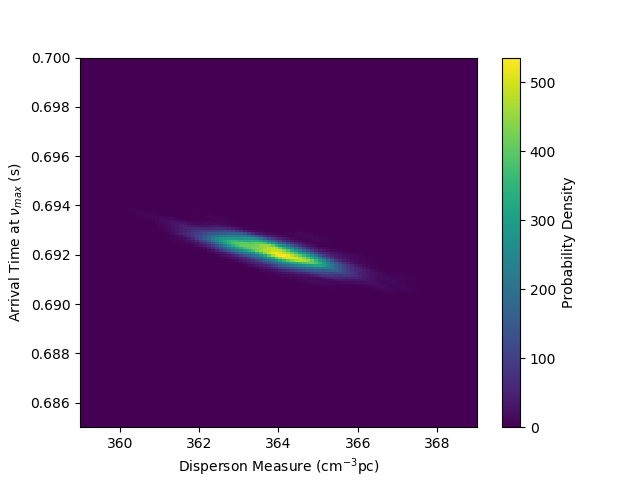

In [14]:
from scipy.stats import gaussian_kde
# compute smoothed 2D probability distribution using a KDE
kernel = gaussian_kde([accepted_time_high_fs, accepted_DMs])
DM_grid, time_high_f_grid = np.meshgrid(np.arange(*prior_DM, .1), np.arange(*prior_time_high_f, .0001))
positions = np.vstack([time_high_f_grid.ravel(), DM_grid.ravel()])
smooth_2D_probability = np.reshape(kernel(positions), DM_grid.shape)

# plot KDE
plt.figure()
plt.imshow(smooth_2D_probability, aspect='auto', origin='lower',
           extent=[prior_DM[0], prior_DM[-1], prior_time_high_f[0], prior_time_high_f[-1]])
plt.xlabel('Disperson Measure (cm$^{-3}$pc)')
plt.ylabel('Arrival Time at $\\nu_{max}$ (s)')
plt.colorbar(label='Probability Density');

Ideally, the smoothed 2D probability distribution should preserve the real features of the original histogram. That appears to be the case here, though smoothing the result of the MCMC can be a bit dangerous.

One nice thing about smoothing is that it lets us produce "corner" plots with confidence contours, which are used extensively in astrophysics and cosmology. Basically, it's a triangle of plots showing the posterior covariance between pairs of parameters and the marginalized posterior of each individual parameter. Traditionally this is done by showing the regions within 1, 2 or (sometimes) 3 sigma, which as discussed encompass ~68%, ~95%, and ~99.7% of the possible results. Using your `accepted_time_high_fs` and `accepted_DMs` below, here's how to make a triangle plot "by hand."

<IPython.core.display.Javascript object>


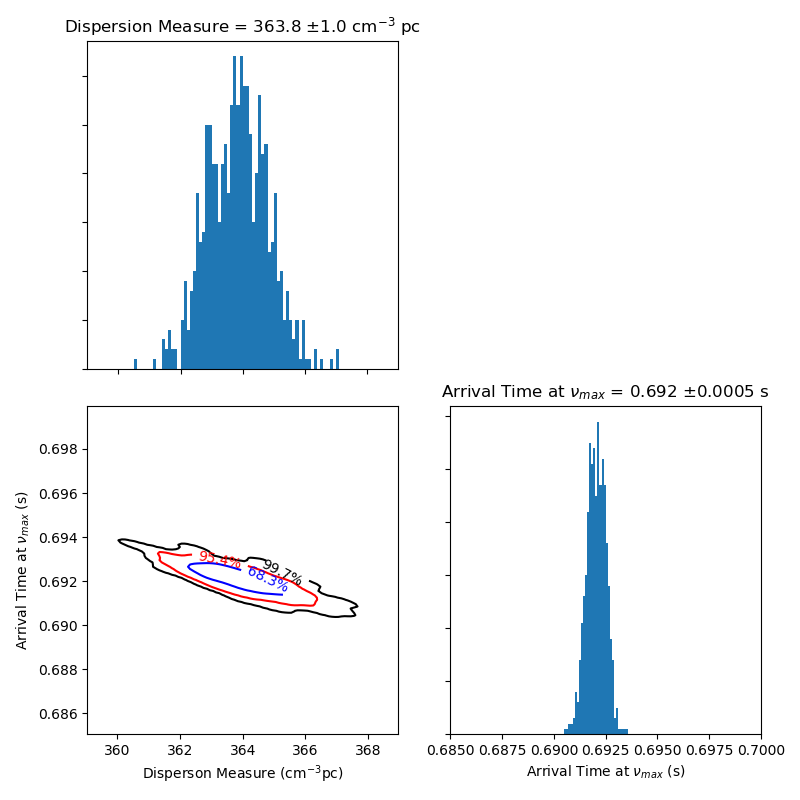

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))#, sharex=True)#, sharey=True)

# Plot contours at 1, 2, and 3, sigma confidence
from scipy.interpolate import interp1d
from scipy.stats import norm
# calculate a function that gives the fraction of weight in smooth_2D_probability above some density
cdf = np.cumsum(sorted(smooth_2D_probability.ravel())) / np.sum(smooth_2D_probability)
probability_density_enclosing = interp1d(cdf, sorted(smooth_2D_probability.ravel()))

# calculate the probability of being within +/- 3, 2, or 1 sigma in a Gaussian distribution
confidence_levels = [(norm.cdf([nSigma]) - norm.cdf([-nSigma]))[0] for nSigma in np.arange(3, 0 , -1)]

# figure out probability density levels associated with 3, 2, or 1 sigma
contour_levels = [probability_density_enclosing(1 - cl) for cl in confidence_levels]

# make contour plot
cs = axes[1, 0].contour(smooth_2D_probability, origin='lower',
                        levels=contour_levels, colors=['k','r','b'],
                        extent=[prior_DM[0], prior_DM[-1], prior_time_high_f[0], prior_time_high_f[-1]])

# add labels to contours
axes[1, 0].clabel(cs, cs.levels, inline=True,
           fmt={lvl: f'{np.round(100 * cl,1)}%' for lvl, cl in zip(cs.levels, confidence_levels)})
axes[1, 0].set_xlabel('Disperson Measure (cm$^{-3}$pc)')
axes[1, 0].set_ylabel('Arrival Time at $\\nu_{max}$ (s)')


# Plot marginalized 1D histograms
axes[0, 0].hist(accepted_DMs, np.arange(*prior_DM, .1))
axes[0, 0].set_xlim(prior_DM)
axes[0, 0].set_yticklabels([])
axes[0, 0].set_xticklabels([])
axes[0, 0].set_title(f'Dispersion Measure = {np.round(np.mean(accepted_DMs), 1)} $\pm$' + 
                     f'{np.round(np.std(accepted_DMs), 1)} cm$^{{-3}}$ pc')

axes[1, 1].hist(accepted_time_high_fs, np.arange(*prior_time_high_f, .0001))
axes[1, 1].set_xlim(prior_time_high_f)
axes[1, 1].set_yticklabels([])
axes[1, 1].set_xlabel('Arrival Time at $\\nu_{max}$ (s)')
axes[1, 1].set_title(f'Arrival Time at $\\nu_{{max}}$ = {np.round(np.mean(accepted_time_high_fs), 4)} $\pm$' + 
                     f'{np.round(np.std(accepted_time_high_fs), 4)} s')

# remove unnecessary axis
axes[0, 1].axis('off')

plt.tight_layout();

## Problem 6: Running the Full 4D MCMC with `emcee` and visualizing the result with `corner`

Going beyond 2 parameters is going to be hard for a the simple Metropolis-Hastings algorithm. In part, this is due to the [*curse of dimensionality*](https://en.wikipedia.org/wiki/Curse_of_dimensionality), which explains why the acceptance rate in 2D was so much lower than 1D. Consider the very simple case where the posterior is flat over half the bounds in each dimension, but 0 elsewhere. For each parameter you pick, there's a 50% chance it'll be acceptable... but if you're picking $N$ parameters, there's only a $2^{-N}$ chance that all the parameters will be acceptable and you'll get a new sample. The larger the number of parameters you're trying to sample of the posterior of, the harder that gets. To solve for many parameters, it helps to have a much more efficient way of making parameter proposals.

As I mentioned before, the basic Metropolis-Hastings algorithm is the simplest MCMC algorithm to understand and implement, but it far from the most efficient. There's lots of others. One popular python package for a much faster MCMC algoirthm is called `emcee`. There's [a whole paper explaining how it works](https://arxiv.org/abs/1202.3665), so I won't go into details. I can't promise that it's the best algorithm for every MCMC problem, but it's certainly a lot better than Metropolis-Hastings.

Before we start with `emcee`, we'll need to define a few functions to compute the log of the prior, the log of the likelihood, and the log of the product of the two. Note that in the prior we're giving very wide bounds on the parameters. That's because the sampler is a lot better at proposing new parameters than a simple uniform distribution.

In [16]:
def log_prior(time_high_f, DM, amp, FWHM_f_high, prior_time_high_f=[0, 2], 
              prior_DM=[100, 1000], prior_amp=[.1, 1], prior_FWHM_high_f=[.004, .1]):
    '''This function implements a uniform prior over given bounds for each of the parameters.
    It returns 0 if the parameters are in bounds and -infinity if not.'''
    if ((prior_time_high_f[0] <= time_high_f <= prior_time_high_f[1]) &
        (prior_DM[0] <= DM <= prior_DM[1]) &
        (prior_amp[0] <= amp <= prior_amp[1]) &
        (prior_FWHM_high_f[0] <= FWHM_f_high <= prior_FWHM_high_f[1])):
        return 0.0
    return -np.inf

def log_likelihood(parameters, time_grid, freq_grid, data, sigma):
    '''This function computes the log of the liklihood, which is just -chisq / 2'''    
    model = generate_gaussian_frb((time_grid, freq_grid), *parameters, ravel=False)
    chisq = np.nansum(np.abs(data - model)**2 / sigma**2)
    return -chisq / 2    

def log_probability(parameters, time_grid, freq_grid, data, sigma):
    '''This function simply computes the log of the product of the prior and the likelihood.
    If the prior is not finite, this function avoids the more expensive calculation of the likelihood.'''
    lp = log_prior(*parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(parameters, time_grid, freq_grid, data, sigma)

Unlike simple Metropolis-Hastings, `emcee` uses multiple "walkers" to create multiple Markov chains in parallel (which also allows the code to be more efficiently parallelized at a large-scale computing facility). These walkers talk to each other and are much more efficient at sampling the posterior. When you use `emcee` you should notice a much higher `acceptance_fraction` than before, which is why you can get 64,000 accepted samples in the time it it takes to get around 1,000 in the 2D MCMC above.

### Perform a 4D MCMC over all 4 parameters of the model, using the above prior and likelihood. 
* ### Plot the accepted and burned proposals for DM as you did in Problem 4 and the distribution of DMs. 
* ### Then use `corner` to make a corner plot of the 2D covariances (with 68% and 95% confidence regions) and marginalized posteriors of all four parameters. 

***Hints: I strongly recommend that you take a look at [the documentation for `emcee`](https://emcee.readthedocs.io/), and likewise for [`corner`](https://corner.readthedocs.io/en/latest/pages/quickstart.html). You may also find [this tutorial helpful](https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html). In particular, I'll note that each walker needs to start in a slightly different place so that they can completely sample the space, so I recommend starting that at the best fit value of the parameters with some small perturbation. For the corner plot you'll find the `levels` keyword useful for plotting confidence intervals. Note that by default, corner will show the densest regions as a 2D histogram with contours and the sparer regions as individual points. This is a fairly standard way to display this kind of information.***

100%|██████████| 2000/2000 [02:31<00:00, 13.23it/s]

From approximately 107472 proposals, 64000 (59.55%) were accepted.
Of these, 6400 were thrown away as burn-in.


<IPython.core.display.Javascript object>


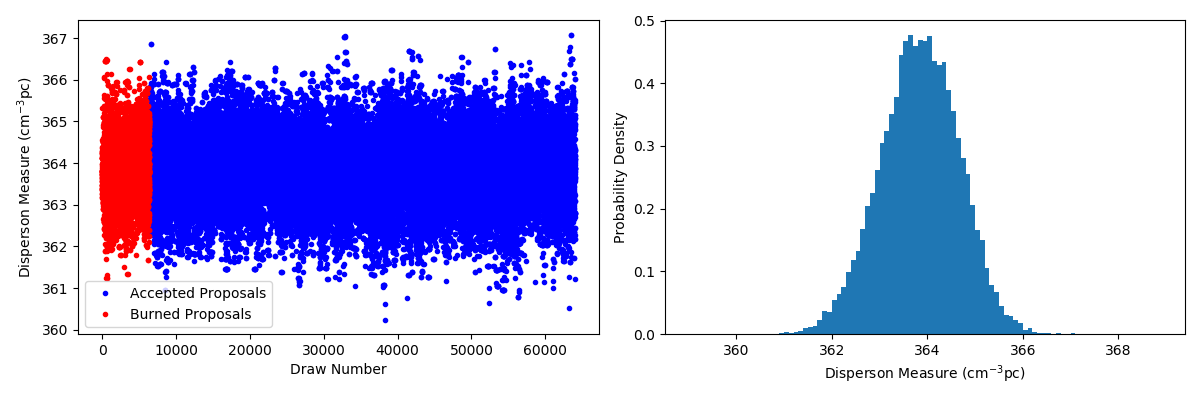

<IPython.core.display.Javascript object>


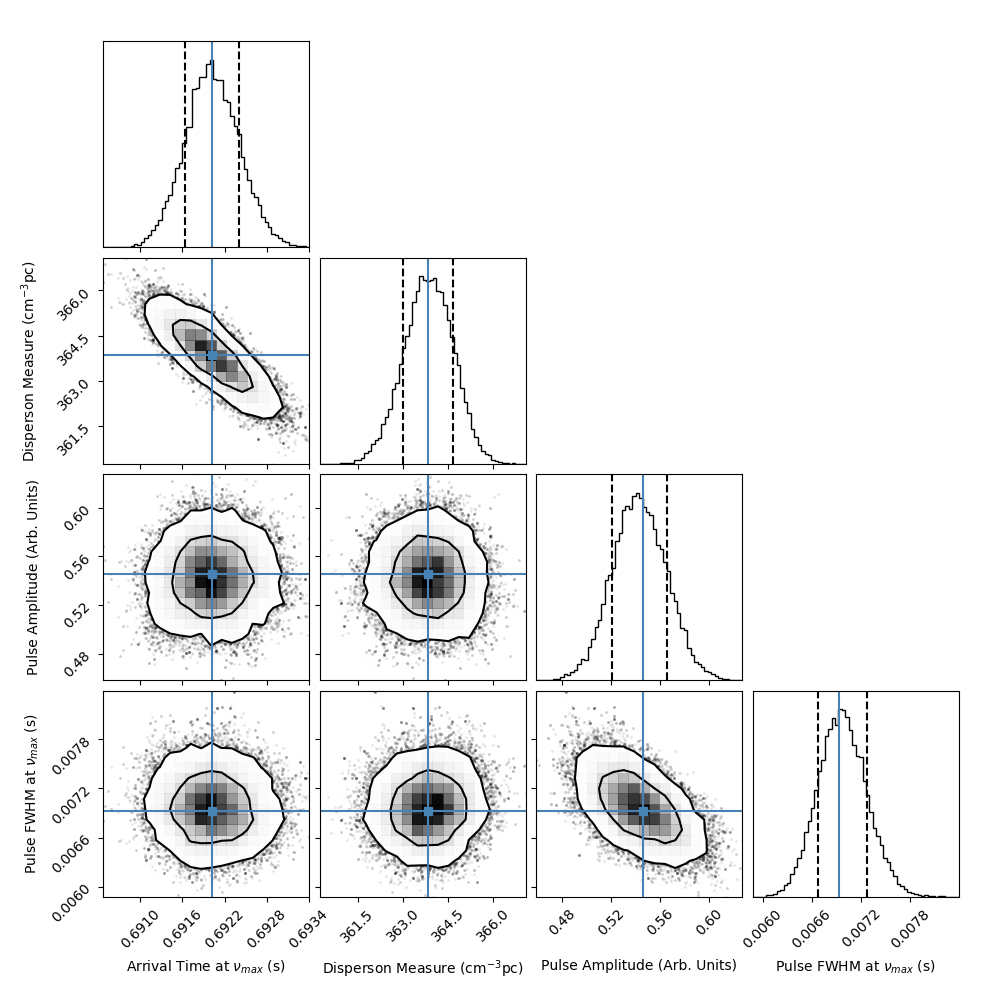

In [17]:
import emcee
import corner # this is a helpful package for turning emcee results into corner plots
nWalkers = 32
nDim = 4 # the number of parameter to solve for
nIter = 2000 # this determines the number of acceptances you get, not the number of proposals

sampler = emcee.EnsembleSampler(# your code here
                                nWalkers, nDim, log_prob_fn=log_probability,
                                args=(time_grid, freq_grid, amplitudes[beam], sigma))
# pick slightly different starting points for the walkers so they better span the space
random_starts = [fit * (1 + 1e-3 * np.random.randn(nDim)) for i in range(nWalkers)]
# run the sampler until each walker gets nIter accepted proposals
sampler.run_mcmc(random_starts, nIter, progress=True)

# count proposals
nProposals = int(np.round(np.sum(nIter / sampler.acceptance_fraction)))
nAccepted = sampler.flatchain.shape[0]
nBurn = nAccepted // 10
accepted_chain = sampler.flatchain[nBurn:]
burned_chain = sampler.flatchain[:nBurn]
print(f'From approximately {nProposals} proposals, {nAccepted} ({np.round(100 * nAccepted / nProposals, 2)}%) were accepted.')
print(f'Of these, {nBurn} were thrown away as burn-in.')

# plot proposals and the histogram of DM 
fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].plot(np.arange(nBurn, nAccepted), accepted_chain[:, 1], 'b.', label='Accepted Proposals')
axes[0].plot(np.arange(nBurn), burned_chain[:, 1], 'r.', label='Burned Proposals')
axes[0].set_xlabel('Draw Number')
axes[0].set_ylabel('Disperson Measure (cm$^{-3}$pc)')
axes[0].legend()

axes[1].hist(accepted_chain[:, 1], np.arange(359, 369, .1), density=True)
axes[1].set_xlabel('Disperson Measure (cm$^{-3}$pc)')
axes[1].set_ylabel('Probability Density')

plt.tight_layout()

# Now use corner to make a corner plot
fig = plt.figure(figsize=(10, 10))
corner.corner(accepted_chain, 
              fig=fig,
              labels=['Arrival Time at $\\nu_{max}$ (s)',
                      'Disperson Measure (cm$^{-3}$pc)',
                      'Pulse Amplitude (Arb. Units)',
                      'Pulse FWHM at $\\nu_{max}$ (s)'],
              hist_bin_factor=3,
              truths=fit, # this shows the best fit values as blue points and lines
              quantiles=[norm.cdf(-1), norm.cdf(1)], # this puts dashed lines at +/- 1σ
              levels=confidence_levels[1:], # this draws the contours at 68% and 95% confidence
             );

## Acknowledgements:

### This work was supported by the National Science Foundation Astronomy and Astrophysics Postdoctoral Fellowship (Award \#1701536).

![](data/nsf.png)